In [1]:
import hydra
from hydra.experimental import compose, initialize
from omegaconf import OmegaConf
import torch
import torchvision.transforms as T
import numpy as np
from nltk.tokenize.treebank import TreebankWordDetokenizer

from exp.gpv.models.gpv import GPV
from utils.detr_misc import collate_fn
from inference_util import *

## Load config

In [2]:
initialize(config_path='configs',job_name='inference')
cfg = compose(config_name='exp/gpv_inference')

/home/tanmayg/miniconda3/envs/gpv-release/lib/python3.6/site-packages/omegaconf/omegaconf.py:579: UserWarning: update() merge flag is is not specified, defaulting to False.
For more details, see https://github.com/omry/omegaconf/issues/367
  stacklevel=1,


## Create model and load checkpoint

In [4]:
model = GPV(cfg.model).cuda().eval()
loaded_dict = torch.load(cfg.ckpt, map_location='cuda:0')['model']
state_dict = model.state_dict()
for k,v in state_dict.items():
    state_dict[k] = loaded_dict[f'module.{k}']
    state_dict[k].requires_grad = False
model.load_state_dict(state_dict)

<All keys matched successfully>

In [5]:
transforms = T.Compose([
    T.ToPILImage(mode='RGB'),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [6]:
def preprocess(inputs,transforms):
    proc_inputs = []
    for img, query in inputs:
        proc_img = (255*img).astype(np.uint8)
        proc_img = transforms(proc_img).cuda()
        proc_inputs.append((proc_img,query))
    
    return collate_fn(proc_inputs)

In [13]:
def decode_outputs(outputs):
    detokenizer = TreebankWordDetokenizer()
    relevance = outputs['pred_relevance_logits'].softmax(-1).detach().cpu().numpy()
    pred_boxes = outputs['pred_boxes'].detach().cpu().numpy()
    topk_answers = torch.topk(outputs['answer_logits'][-1],k=1,dim=-1)
    topk_answer_ids = topk_answers.indices.detach().cpu().numpy()
    pred_answers = model.token_ids_to_words(topk_answer_ids[:,:,0])
    decoded_outputs = []
    for b in range(len(pred_answers)):
        scores, boxes = zip(*sorted(zip(
            relevance[b,:,0].tolist(),pred_boxes[b].tolist()),
            key=lambda x: x[0],reverse=True))
        scores = np.array(scores,dtype=np.float32)
        boxes = np.array(boxes,dtype=np.float32)
        answer = []
        for token in pred_answers[b]:
            if token in ['__stop__','__pad__']:
                break
            answer.append(token)
        answer = detokenizer.detokenize(answer)
        decoded_outputs.append({
            'answer': answer,
            'boxes': boxes,
            'relevance': scores})
    
    return decoded_outputs

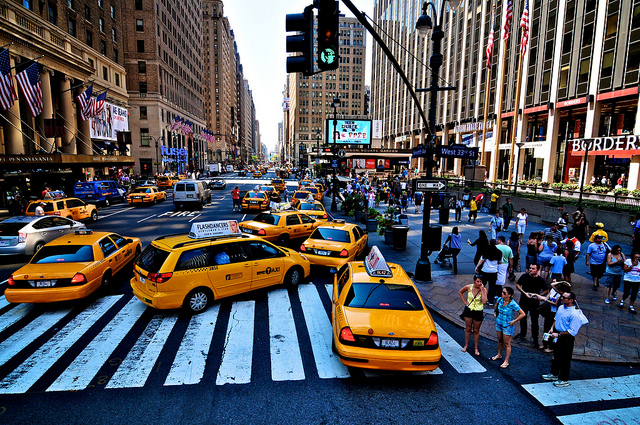

In [16]:
img,_ = read_image('assets/busy_street.png',resize_image=False)
imshow((255*img[:,:,::-1]).astype(np.uint8)) # scale pixel values, RGB to BGR (because imshow uses opencv), and convert to uint8

In [20]:
inputs = [
    (img,'What color are the cars?'),
    (img,'How many cars are there?'),
    (img,'Find the blue van.'),
    (img,'Describe the image.')]

In [21]:
images, queries = preprocess(inputs,transforms)
outputs = model(images,queries,None)
predictions = decode_outputs(outputs)

--------------------------------------------------------------------------------
Query 0: What color are the cars?
Ans: yellow and blue


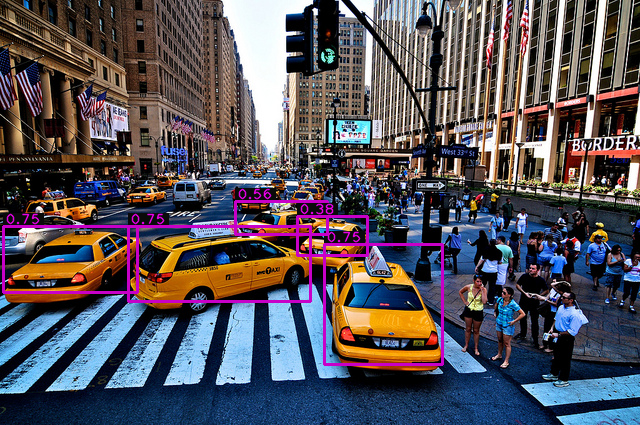

--------------------------------------------------------------------------------
Query 1: How many cars are there?
Ans: 30


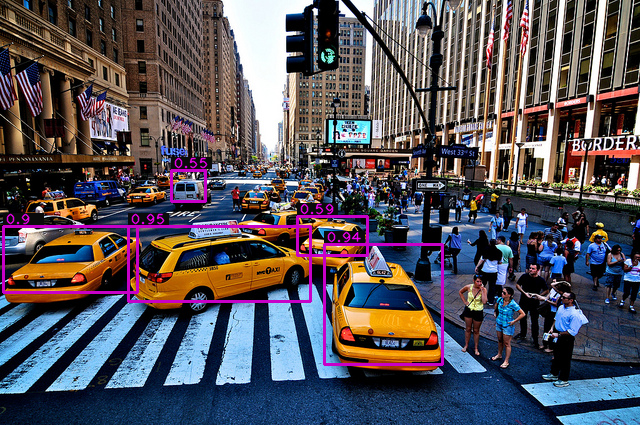

--------------------------------------------------------------------------------
Query 2: Find the blue van.
Ans: cars


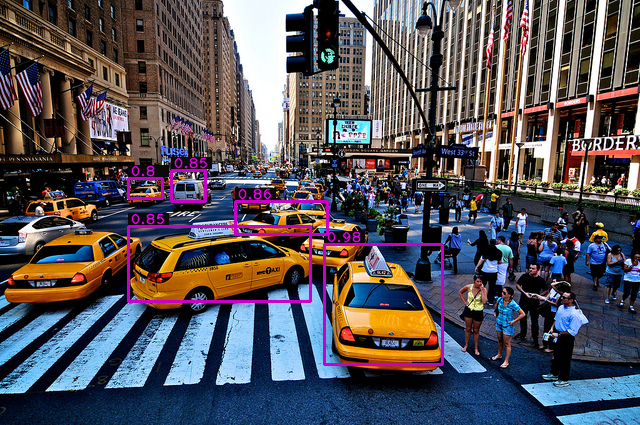

--------------------------------------------------------------------------------
Query 3: Describe the image.
Ans: a busy city street with cars and people walking on the sidewalk.


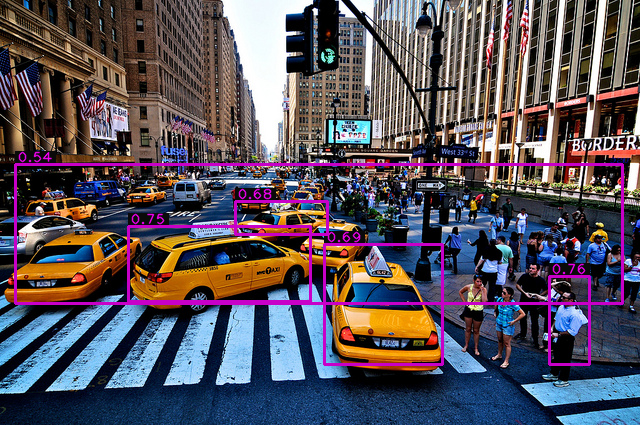

In [22]:
for i, (query, prediction) in enumerate(zip(queries,predictions)):
    print('-'*80)
    print(f'Query {i}:',query)
    print(f'Ans:', prediction['answer'])
    vis_img = vis_sample('assets/busy_street.png',prediction,5)
    imshow(vis_img)
